<a href="https://colab.research.google.com/github/Flippo13/Deep-Learning-project/blob/main/Copy_of_CNN_dft_defense_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image

import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def loadDataset(dirImg, dirClass, numimages):
  classesFile = open(os.path.join(dirClass,"classes.txt"), "r")
  classes = []
  imported = 0

  for line in classesFile:
    classes.append(line.rstrip("\n"))
  print("Number of classes: %d"%(len(classes)))
  imgs = np.ones([numimages, 224, 224, 3], np.uint8)
  i  = 0
  for c in classes:
    imgpath = (os.listdir(os.path.join(dirImg,c)))

    for path in imgpath:
      path = os.path.join(dirImg, c, path)
      imgs[i] = cv2.resize(np.array(cv2.cvtColor(cv2.imread(os.path.join(path)), cv2.COLOR_BGR2RGB),np.uint8), (224, 224))
      i = i +1

    imported = imported + len(imgpath)
    print("%s images: %d (%f %%)"%(c, len(imgpath), (imported/numimages * 100)))


  classesFile.close()
  return [imgs]

def loadLabels(dirImg, dirClass, numimages):
  classes = []
  classesFile = open(os.path.join(dirClass,"classes.txt"), "r")
  for line in classesFile:
      classes.append(line.rstrip("\n"))

  label = 0
  Y = [None]*numimages
  imgs_per_class =[None]*len(classes)
  index = 0
  for c in classes:
    nimg = len(os.listdir(os.path.join(dirImg, c)))
    imgs_per_class[label] = nimg
    print(c, nimg)
    for i in range(0, nimg):
      Y[index] = label
      index += 1

    label = label + 1

  classesFile.close()
  return Y, classes, imgs_per_class


In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
dirImg = '/content/gdrive/MyDrive/DeepLearningHomework/PokemonData'
dirClass = '/content/gdrive/MyDrive/DeepLearningHomework'
total = 11945;

In [ ]:
[X] = loadDataset(dirImg, dirClass, total)
for i in range(0, len(X)):
  X[i] = Image.fromarray(X[i])

In [ ]:
# Y returns as int values from 1 to 151, classes has the class name
# they both map eachother
Y, classes, imgs_per_class= loadLabels(dirImg, dirClass, total)
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/imgs', X)
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/labels', Y)
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/classes', classes)
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/imgsperclasses', imgs_per_class)

11945 11945
1


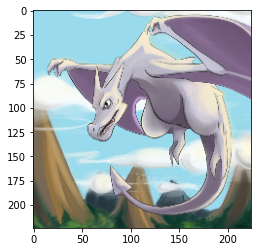

In [ ]:
X = np.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/imgs.npy')
Y = np.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/labels.npy')
classes = np.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/classes.npy')
imgs_per_class = np.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/imgsperclasses.npy')

for i in range(0, len(X)):
  X[i] = Image.fromarray(X[i])

print(len(Y), len(X))
plt.imshow(X[71])
print(Y[71])

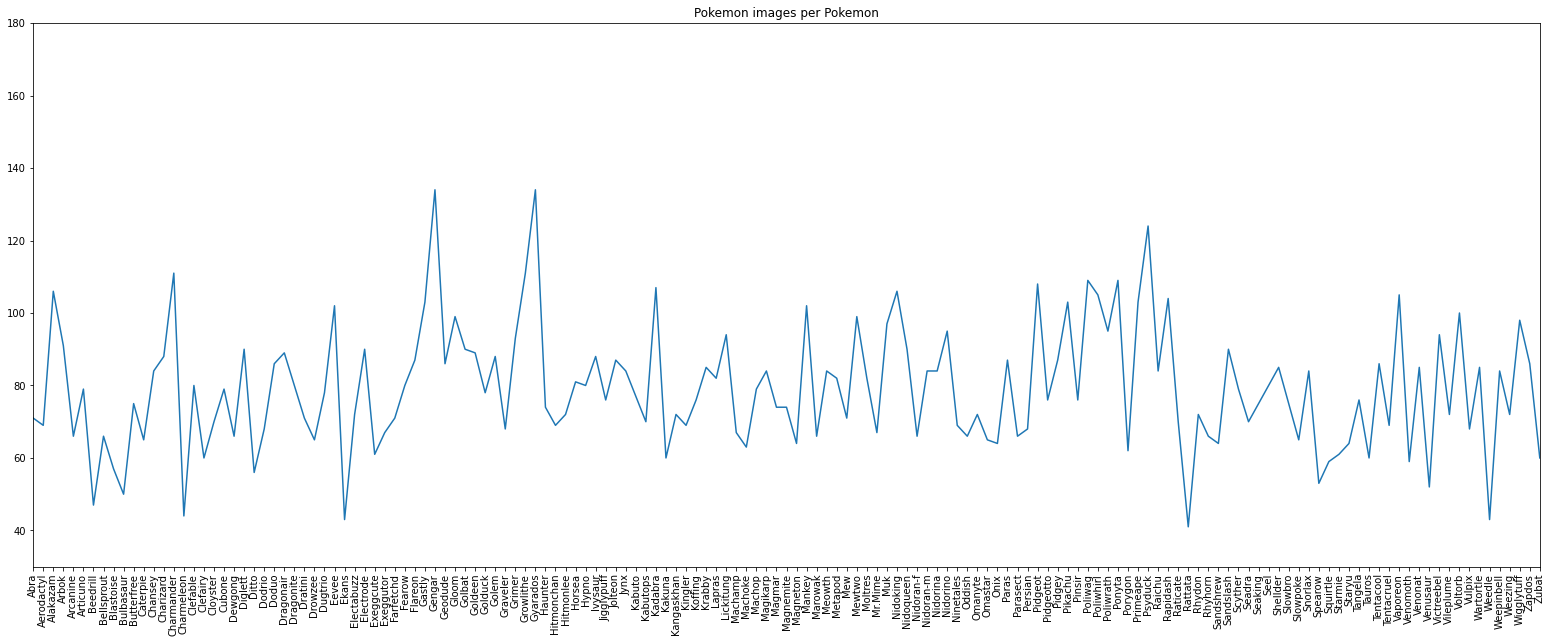

In [ ]:
# Data distribuition
fig = plt.figure(figsize = (27, 10))
plt.plot(classes, imgs_per_class)
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.ylim(30,180)
plt.title("Pokemon images per Pokemon")
plt.show()

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, labels, transform=None):
      self.labels = labels
      self.imgs = imgs
      self.transforms = transform

    def __len__(self):
      return len(self.imgs)

    def __getitem__(self, index):
      X = self.imgs[index]
      y = self.labels[index]

      if self.transforms:
        X = self.transforms(X)


      return X,y



def split_train_test(X, Y, splitsize=0.2, batch_size=64):
  train_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]), #normalizing the data between 0 and 1
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(15)
                                        ])

  test_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])


  from sklearn.utils import shuffle
  data, labels =  shuffle(X, Y, random_state=0) #shuffling the data


  pokemon_train_data = Dataset(data[:np.uint16(np.floor(len(data)*(1-splitsize)))],
                               labels[:np.uint16(np.floor(len(data)*(1-splitsize)))], transform=train_transform)
  pokemon_test_data = Dataset(data[np.uint16(np.floor(len(data)*(1-splitsize))):],
                              labels[np.uint16(np.floor(len(data)*(1-splitsize))):], transform=test_transform)

  trainloader = torch.utils.data.DataLoader(pokemon_train_data,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          num_workers = 2)

  testloader = torch.utils.data.DataLoader(pokemon_test_data,
                                           batch_size=batch_size,
                                           shuffle = False,
                                           num_workers = 2)

  # total_mean, total_std = Normalization(trainloader, pokemon_train_data)

  # train_transform = transforms.Compose([transforms.ToTensor(),
  #                                       transforms.Normalize(mean = total_mean, std=total_std)])

  # pokemon_train_data = Dataset(data[:np.uint16(np.floor(len(data)*(1-splitsize)))],
  #                              labels[:np.uint16(np.floor(len(data)*(1-splitsize)))], transform=train_transform)



  return trainloader, testloader, pokemon_train_data, pokemon_test_data

def Normalization(trainloader, traindata):
  #find values
  from tqdm import tqdm
  psum    = torch.tensor([0.0, 0.0, 0.0])
  psum_sq = torch.tensor([0.0, 0.0, 0.0])

  # loop through images
  for (image, label) in tqdm(trainloader):
      psum    += image.sum(axis       = [0, 2, 3])
      psum_sq += (image ** 2).sum(axis = [0, 2, 3])

  image_size = 224
  count = len(traindata) * image_size * image_size

  # mean and std
  total_mean = psum / count
  total_var  = (psum_sq / count) - (total_mean ** 2)
  total_std  = torch.sqrt(total_var)

  # output
  print('\n mean: '  + str(total_mean))
  print('std:  '  + str(total_std))

  return total_mean, total_std

In [ ]:
batchsize = 32
trainloader, testloader, traindata, testdata = split_train_test(X, Y, batch_size=batchsize)

train: 9556 test: 2389 total: 11945
image.shape: torch.Size([32, 3, 224, 224])


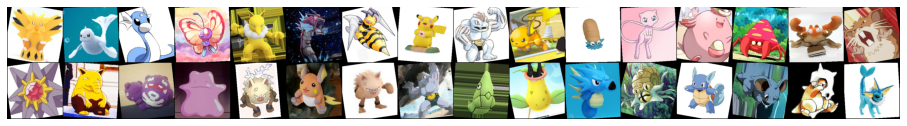

In [ ]:
from torchvision.utils import make_grid
print("train:",len(traindata), "test:", len(testdata), "total: %d"%(len(testdata)+len(traindata)))

for images,_ in trainloader: #visualize a random batch
  print('image.shape:', images.shape)
  plt.figure(figsize=(16,16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        model.train()
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(inputs)

            loss = criterion(y_pred, labels)

            loss.backward()

            optimizer.step()

            # calculate the loss/acc later
            y_pred_max = torch.argmax(y_pred, dim=1)

            running_loss += loss.item()

            correct = torch.sum(torch.eq(y_pred_max, labels)).item()

            running_correct += correct

            if not i % 20:
              print(f'epoch: {epoch+1}, loss: {loss.item():.3f}, train accuracy: {correct / batchsize:.3f}')

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 1/batchsize*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # switch the model to eval mode to evaluate on test data
        model.eval()
        correct_total = 0
        for i, data in enumerate(testloader):
          x_batch, y_batch = data

          x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

          y_pred = net(x_batch)
          y_pred_max = torch.argmax(y_pred, dim=1)

          correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

        test_acc = correct_total / len(testdata)
        print(f'Accuracy on the test set: {test_acc:.3f}')

        test_accuracies.append(test_acc)
        scheduler.step(test_acc)

    return model, losses, accuracies, test_accuracies

In [ ]:
class DFT(nn.Module):
  def __init__(self,w, h, r):
    super(DFT, self).__init__()
    self.w = w
    self.h = h
    self.r = r
    self.template()

  def template(self):
    temp = np.zeros((self.w, self.h), "float32")
    cw = self.w // 2
    ch = self.h // 2 #to center it.

    if self.w % 2 == 0:
            dw = self.r
    else:
        dw = self.r + 1

    if self.h % 2 == 0:
        dh = self.r
    else:
        dh = self.r + 1

    temp[cw - self.r:cw + dw, ch - self.r:ch + dh] = 1.0 #value of the center pixel
    temp = np.roll(temp, -cw, axis=0)
    temp = np.roll(temp, -ch, axis=1)
    temp = torch.tensor(temp)
    #temp = temp.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
    self.temp = temp
    if torch.cuda.is_available():
        self.temp = self.temp.cuda()

  def forward(self, x):
    x_hat = torch.fft.fftn(x)
    x_hat = x_hat * self.temp
    y = torch.fft.irfftn(x_hat)
    return y

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available()
                                  else "cpu")
net = models.resnet18(pretrained=True)

num_ftrs = net.fc.in_features

n_classes = len(classes)

dft = DFT(224,224,8)
dft_model = nn.Sequential(dft)

net.fc = nn.Sequential(nn.Linear(num_ftrs, n_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9) #reduces the learning rate if the test_accuracy stagnates for 3 epochs

net = nn.Sequential(dft_model,net)

net.to(device)

In [ ]:
net, training_losses, training_accs, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=10)

In [ ]:
torch.save(net.state_dict(), '/content/gdrive/MyDrive/DL/DeepLearningHomework/resnet18_dft')
trainingdata = [training_losses, training_accs]
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/resnet18losses_dft', trainingdata)

In [ ]:
net_state = torch.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/resnet18_dft_felix', map_location=device)
net.load_state_dict(net_state)

<All keys matched successfully>

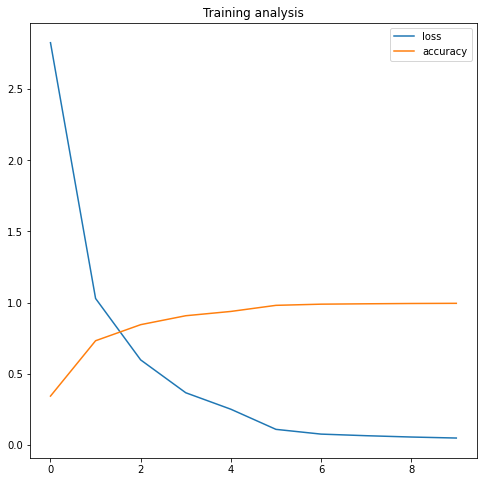

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(trainingdata[0])
plt.plot(trainingdata[1])
plt.title("Training analysis")
l = ["loss", "accuracy"]
plt.legend(l)

In [ ]:
net.eval()
correct_total = 0
for i, data in enumerate(testloader):
  x_batch, y_batch = data

  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  y_pred = net(x_batch)
  y_pred_max = torch.argmax(y_pred, dim=1)

  correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

test_acc = correct_total / len(testdata)
print(f'Accuracy on the test set: {test_acc:.3f}')

Accuracy on the test set: 0.846


In [ ]:
!pip install git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-sk6wxw2h
  Running command git clone -q https://github.com/fra31/auto-attack /tmp/pip-req-build-sk6wxw2h


In [ ]:
l = [x for (x,y) in testloader]
x_test = torch.cat(l,0)
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/test_images',x_test.numpy())

l = [y for (x,y) in testloader]
y_test = torch.cat(l,0)

np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/test_labels',y_test.numpy())

In [ ]:
l = np.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/test_images.npy')
x_test = torch.from_numpy(l)

l = np.load('/content/gdrive/MyDrive/DL/DeepLearningHomework/test_labels.npy')
y_test = torch.from_numpy(l)

In [ ]:
from autoattack import AutoAttack

norm = 'Linf'
eps = 2*8./255.
logpath = './log_file.txt'
save_dir = 'savedADVS'
attacks = ['apgd-ce', 'apgd-dlr', 'fab', 'square', 'fab-t', 'apgd-t']
at_t_run = [attacks[5], attacks[2]]


adversary = AutoAttack(net, norm=norm, eps=eps, log_path=logpath,
        version='standard')

setting parameters for standard version


In [ ]:
stopidx = 512
bs = 32

with torch.no_grad():
    x_adv, y_adv = adversary.run_standard_evaluation(x_test[:stopidx], y_test[:stopidx], bs=bs, return_labels=True)


using standard version including apgd-ce, apgd-t, fab-t, square
initial accuracy: 89.06%
apgd-ce - 1/15 - 32 out of 32 successfully perturbed
apgd-ce - 2/15 - 32 out of 32 successfully perturbed
apgd-ce - 3/15 - 32 out of 32 successfully perturbed
apgd-ce - 4/15 - 32 out of 32 successfully perturbed
apgd-ce - 5/15 - 32 out of 32 successfully perturbed
apgd-ce - 6/15 - 32 out of 32 successfully perturbed
apgd-ce - 7/15 - 32 out of 32 successfully perturbed
apgd-ce - 8/15 - 32 out of 32 successfully perturbed
apgd-ce - 9/15 - 32 out of 32 successfully perturbed
apgd-ce - 10/15 - 32 out of 32 successfully perturbed
apgd-ce - 11/15 - 32 out of 32 successfully perturbed
apgd-ce - 12/15 - 32 out of 32 successfully perturbed
apgd-ce - 13/15 - 31 out of 32 successfully perturbed
apgd-ce - 14/15 - 32 out of 32 successfully perturbed
apgd-ce - 15/15 - 7 out of 8 successfully perturbed
robust accuracy after APGD-CE: 0.39% (total time 663.6 s)
apgd-t - 1/1 - 1 out of 2 successfully perturbed
robus

In [ ]:
np_x_adv = (x_adv.cpu().detach().numpy())

x_adv_np = np.zeros((1024, 224, 224, 3))

for i, x in enumerate(np_x_adv):
  x_adv_np[i] = np.transpose(np_x_adv[i], (1,2,0))


np_y_adv = y_adv.cpu().numpy()

In [ ]:
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/adv_imgs_eps8_dft', x_adv_np)
np.save('/content/gdrive/MyDrive/DL/DeepLearningHomework/adv_labels_eps8_dft', np_y_adv)

plt.imshow(x_adv_np[1])
print(classes[np_y_adv[1]])